# Social and Governmental Data for Score

## Notebook Description
This notebook is used to prepare the social and governmental score based on several indicators from the ESG Sovereign Data Framework

## Data Source
**World Bank Sovereign ESG Data Portal**

The World Bank curates and maintains a wide range of ESG data: [Sovereign ESG Data Framework](https://esgdata.worldbank.org/data/framework?lang=en)

To obtain the ESG data framework visit the [download page](https://esgdata.worldbank.org/data/download?lang=en)

## Imports

In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sql_functions as sf
from transform_esg import melt_pivot 
from transform_esg import interpol
from transform_esg import lin_reg
from transform_esg import per_null
from transform_esg import nan_scanner_comb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
#plot Style
sns.set_style("whitegrid")

## Data Loading

In [4]:
df_esg = pd.read_csv('data/sovereignesg-data_2022.csv', sep=';')


/var/folders/lq/66qmb5qs6yx8s8h1s8rmqnh80000gn/T/ipykernel_11043/749654921.py:1: DtypeWarning: Columns (2,3,4,5,6,7,9,10,11,15,16,17,19,20,22,26,29,30,31,32,33,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df_esg = pd.read_csv('data/sovereignesg-data_2022.csv', sep=';')


In [5]:
df_esg.head()

,iso3,ind,1960,1961,1962,1963,1964,1965,1966,1967,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,AFG,AG.LND.AGRI.ZS,NaN,57.745918,57.837821,57.914407,58.010906,58.013969,58.072175,58.173268,...,58.06758,58.06758,58.06758,58.06758,58.06758,58.06758,58.081365,NaN,NaN,NaN
1,AGO,AG.LND.AGRI.ZS,NaN,45.857063,45.881126,45.897169,45.921232,45.937274,45.961338,45.985401,...,43.011249,43.456474,43.901699,44.346924,44.792155,45.237371,45.682594,NaN,NaN,NaN
2,ALB,AG.LND.AGRI.ZS,NaN,44.963504,44.963504,45.0,44.890511,45.145985,45.255474,45.40146,...,43.843066,43.332117,42.857299,42.857664,43.127737,42.670839,42.849672,NaN,NaN,NaN
3,AND,AG.LND.AGRI.ZS,NaN,55.319149,55.319149,55.319149,55.319149,55.319149,55.319149,55.319149,...,39.914894,40.021277,40.0,40.021277,40.042553,40.042553,40.06383,NaN,NaN,NaN
4,ARE,AG.LND.AGRI.ZS,NaN,2.928752,2.928752,2.928752,2.928752,2.942833,2.956914,2.956914,...,5.30414,5.342157,5.385807,5.390031,5.404112,5.404112,5.375246,NaN,NaN,NaN


In [6]:
df_esg.shape

(24355, 64)

### Choice of indicators based for social and governmental sustainability
Due to the quality of the environmental indicators, a different dataset is used for the environmental indicators. See notebook **esg_data_env**

### Description of the variables

- `EG.ELC.ACCS.ZS`: Access to electricity (% of population).
- `SP.DYN.LE00.IN`: Life expectancy at birth, total (years)
- `SE.XPD.TOTL.GB.ZS`: Government expenditure on education, total (% of government expenditure).
- `SL.UEM.TOTL.ZS`: Unemployment, total (% of total labor force) (modeled ILO estimate).
- `SH.DYN.MORT`: Mortality rate, under-5 (per 1,000 live births).
- `IT.NET.USER.ZS`: Individuals using the Internet (% of population).
`VA.EST`: Voice and Accountability: Estimate - Perceptions Of The Extent To Which A Country's Citizens Are Able To Participate In Selecting Their Government.
- `CC.EST`: Control of Corruption: Estimate.
- `PV.EST`: Political Stability and Absence of Violence/Terrorism: Estimate.
- `RL.EST`: Rule of Law: Estimate.

In [7]:
# List with selected Indicators for social and governmental

soc_ind = ['EG.ELC.ACCS.ZS',
           'SP.DYN.LE00.IN',
           'SE.XPD.TOTL.GB.ZS',
           'SL.UEM.TOTL.ZS',
           'SH.DYN.MORT',
           ]

gov_ind = ['IT.NET.USER.ZS',
           'VA.EST',
           'CC.EST',
           'PV.EST',
           'RL.EST'
           ]

### Rename columns and select only official countries

In [8]:
df_esg = df_esg.rename(columns={'Country Code':'iso3', 'Indicator Code':'ind'})

In [9]:
df_esg['iso3'].nunique()

289

In [10]:
from country_iso_dict import list_off

In [11]:
df_esg = df_esg[df_esg['iso3'].isin(list_off)]

In [12]:
df_esg['iso3'].nunique()

193

### Selection of the columns and the requested years

In [13]:
col_to_keep = ['iso3', 'ind', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

In [14]:
df_esg = df_esg.loc[:,col_to_keep]

In [15]:
df_esg

,iso3,ind,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,AFG,AG.LND.AGRI.ZS,58.06758,58.06758,58.06758,58.06758,58.06758,58.06758,58.081365,NaN,NaN,NaN
1,AGO,AG.LND.AGRI.ZS,43.011249,43.456474,43.901699,44.346924,44.792155,45.237371,45.682594,NaN,NaN,NaN
2,ALB,AG.LND.AGRI.ZS,43.843066,43.332117,42.857299,42.857664,43.127737,42.670839,42.849672,NaN,NaN,NaN
3,AND,AG.LND.AGRI.ZS,39.914894,40.021277,40.0,40.021277,40.042553,40.042553,40.06383,NaN,NaN,NaN
4,ARE,AG.LND.AGRI.ZS,5.30414,5.342157,5.385807,5.390031,5.404112,5.404112,5.375246,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
24350,VNM,EG.ELC.ACCS.RU.ZS,97.00138092,97.87874603,98.85342407,99.73003387,98.77844238,100,100,99.053207,100.0,NaN
24351,VUT,EG.ELC.ACCS.RU.ZS,29.84954834,13.7641201,36.17450714,39.89191437,46.58963776,52.93933487,51.04706192,54.396469,57.650364,NaN
24352,YEM,EG.ELC.ACCS.RU.ZS,29.26478958,64.03333282,50.62494278,53.5731163,55.66996002,71.4414444,50.43110106,60.676804,61.941116,NaN
24353,ZAF,EG.ELC.ACCS.RU.ZS,81.42615509,80.73778534,82.28664398,80.19794464,75.74927521,76.73898315,77.16849518,77.611824,75.264854,NaN


In [16]:
df_esg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23309 entries, 0 to 24354
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   iso3    23309 non-null  object 
 1   ind     23309 non-null  object 
 2   2012    19357 non-null  object 
 3   2013    19129 non-null  object 
 4   2014    19196 non-null  object 
 5   2015    18899 non-null  object 
 6   2016    18436 non-null  object 
 7   2017    18784 non-null  object 
 8   2018    18360 non-null  object 
 9   2019    8993 non-null   float64
 10  2020    7265 non-null   object 
 11  2021    2245 non-null   float64
dtypes: float64(2), object(10)
memory usage: 2.3+ MB


In [17]:
col_num = ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

for i in col_num:
    df_esg[i] = pd.to_numeric(df_esg[i], downcast='float', errors='coerce')

In [18]:
df_esg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23309 entries, 0 to 24354
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   iso3    23309 non-null  object 
 1   ind     23309 non-null  object 
 2   2012    19351 non-null  float64
 3   2013    19118 non-null  float64
 4   2014    19192 non-null  float64
 5   2015    18893 non-null  float64
 6   2016    18428 non-null  float64
 7   2017    18772 non-null  float64
 8   2018    18278 non-null  float64
 9   2019    8993 non-null   float64
 10  2020    7264 non-null   float64
 11  2021    2245 non-null   float64
dtypes: float64(10), object(2)
memory usage: 2.3+ MB


In [19]:
df_esg.head(10)

,iso3,ind,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,AFG,AG.LND.AGRI.ZS,58.067580,58.067580,58.067580,58.067580,58.067580,58.067580,58.081365,NaN,NaN,NaN
1,AGO,AG.LND.AGRI.ZS,43.011249,43.456474,43.901699,44.346924,44.792155,45.237371,45.682594,NaN,NaN,NaN
2,ALB,AG.LND.AGRI.ZS,43.843066,43.332117,42.857299,42.857664,43.127737,42.670839,42.849672,NaN,NaN,NaN
3,AND,AG.LND.AGRI.ZS,39.914894,40.021277,40.000000,40.021277,40.042553,40.042553,40.063830,NaN,NaN,NaN
4,ARE,AG.LND.AGRI.ZS,5.304140,5.342157,5.385807,5.390031,5.404112,5.404112,5.375246,NaN,NaN,NaN
5,ARG,AG.LND.AGRI.ZS,54.538146,54.518049,54.335712,54.335712,54.335712,54.335712,54.360560,NaN,NaN,NaN
6,ARM,AG.LND.AGRI.ZS,59.114858,59.114858,59.034071,58.893572,58.897085,58.872497,58.914647,NaN,NaN,NaN
7,ATG,AG.LND.AGRI.ZS,20.454545,20.454545,20.454545,20.454545,20.454545,20.454545,20.454545,NaN,NaN,NaN
8,AUS,AG.LND.AGRI.ZS,50.385431,48.393710,48.738399,45.314424,44.539926,48.340618,46.658095,NaN,NaN,NaN
9,AUT,AG.LND.AGRI.ZS,33.132253,32.913693,32.890225,32.942923,32.357853,32.169413,32.147722,NaN,NaN,NaN


### Social Indicators

In [20]:
df_soc = df_esg[df_esg['ind'].isin(soc_ind)]

In [21]:
df_soc.head()

,iso3,ind,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
1176,AFG,EG.ELC.ACCS.ZS,69.099998,68.290649,89.500000,71.500000,97.699997,97.699997,96.616135,97.699997,97.699997,NaN
1177,AGO,EG.ELC.ACCS.ZS,37.131321,38.278030,32.000000,42.000000,41.813129,43.013260,45.290001,45.642799,46.890610,NaN
1178,ALB,EG.ELC.ACCS.ZS,99.900002,100.000000,99.949997,99.980003,99.889999,99.889999,100.000000,100.000000,100.000000,NaN
1179,AND,EG.ELC.ACCS.ZS,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,NaN
1180,ARE,EG.ELC.ACCS.ZS,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,NaN


In [22]:
df_soc_trans = melt_pivot(df_soc)

In [23]:
df_soc_trans

ind,iso3,variable,EG.ELC.ACCS.ZS,SE.XPD.TOTL.GB.ZS,SH.DYN.MORT,SL.UEM.TOTL.ZS,SP.DYN.LE00.IN
0,AFG,2012,69.099998,NaN,80.3,11.341,62.054
1,AFG,2013,68.290649,14.102800,76.9,11.193,62.525
2,AFG,2014,89.500000,14.465930,73.6,11.142,62.966
3,AFG,2015,71.500000,12.509000,70.4,11.127,63.377
4,AFG,2016,97.699997,13.091000,67.5,11.158,63.763
...,...,...,...,...,...,...,...
1925,ZWE,2017,44.178635,20.874201,57.0,4.785,60.812
1926,ZWE,2018,45.572647,19.039841,54.8,4.796,61.195
1927,ZWE,2019,46.781475,NaN,54.2,4.833,61.490
1928,ZWE,2020,52.747669,NaN,53.9,5.351,61.738


In [24]:
df_soc_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1930 entries, 0 to 1929
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   iso3               1930 non-null   object 
 1   variable           1930 non-null   object 
 2   EG.ELC.ACCS.ZS     1737 non-null   float64
 3   SE.XPD.TOTL.GB.ZS  1166 non-null   float64
 4   SH.DYN.MORT        1728 non-null   float64
 5   SL.UEM.TOTL.ZS     1780 non-null   float64
 6   SP.DYN.LE00.IN     1656 non-null   float64
dtypes: float64(5), object(2)
memory usage: 105.7+ KB


In [25]:
df_soc_trans = df_soc_trans.rename(columns={'variable':'year'})

In [26]:
df_soc_trans['year'] = pd.to_datetime(df_soc_trans['year'], format='%Y', errors='coerce')

### Governmental Indicators

In [27]:
df_gov = df_esg[df_esg['ind'].isin(gov_ind)]

In [28]:
df_gov.head()

,iso3,ind,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
580,AFG,CC.EST,-1.419741,-1.436510,-1.354829,-1.342216,-1.526172,-1.515626,-1.487624,-1.400733,-1.475405,NaN
581,AGO,CC.EST,-1.268470,-1.309463,-1.443944,-1.395014,-1.439528,-1.410953,-1.139192,-1.054451,-0.927093,NaN
583,ALB,CC.EST,-0.726491,-0.698432,-0.548164,-0.479035,-0.405149,-0.420722,-0.478632,-0.533089,-0.540196,NaN
584,AND,CC.EST,1.267989,1.260759,1.225432,1.218931,1.228804,1.245126,1.239041,1.234696,1.314374,NaN
586,ARE,CC.EST,1.163153,1.280802,1.203786,1.072319,1.171737,1.136438,1.152078,1.106673,1.114396,NaN


In [29]:
df_gov_trans = melt_pivot(df_gov)

In [30]:
df_gov_trans

ind,iso3,variable,CC.EST,IT.NET.USER.ZS,PV.EST,RL.EST,VA.EST
0,AFG,2012,-1.419741,5.454545,-2.418561,-1.643081,-1.267430
1,AFG,2013,-1.436510,5.900000,-2.519349,-1.597348,-1.240068
2,AFG,2014,-1.354829,7.000000,-2.411068,-1.445761,-1.135445
3,AFG,2015,-1.342216,8.260000,-2.571222,-1.504086,-1.117563
4,AFG,2016,-1.526172,11.000000,-2.671054,-1.498478,-1.037838
...,...,...,...,...,...,...,...
1925,ZWE,2017,-1.271278,24.400000,-0.708769,-1.373646,-1.195013
1926,ZWE,2018,-1.230871,25.000000,-0.722774,-1.272543,-1.140979
1927,ZWE,2019,-1.236825,25.100000,-0.959749,-1.257262,-1.159892
1928,ZWE,2020,-1.253140,29.300000,-1.080208,-1.274851,-1.121479


In [31]:
df_gov_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1930 entries, 0 to 1929
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   iso3            1930 non-null   object 
 1   variable        1930 non-null   object 
 2   CC.EST          1719 non-null   float64
 3   IT.NET.USER.ZS  1586 non-null   float64
 4   PV.EST          1737 non-null   float64
 5   RL.EST          1723 non-null   float64
 6   VA.EST          1737 non-null   float64
dtypes: float64(5), object(2)
memory usage: 105.7+ KB


In [32]:
df_gov_trans = df_gov_trans.rename(columns={'variable':'year'})

In [33]:
df_gov_trans['year'] = pd.to_datetime(df_gov_trans['year'], format='%Y', errors='coerce')

In [34]:
#for i in gov_ind:
    #df_gov_trans.plot(x='variable', y= i)

## Handling Missing Values

**DATA IMPUTATION FOR SOCIAL**

In [35]:
df_soc_imp = df_soc_trans.copy()

In [36]:
#interpolation
df_soc_imp = interpol(df_soc_imp, soc_ind)

In [37]:
#linear regression Imputation
#df_soc_imp = lin_reg(df_soc_imp, soc_ind)

In [38]:
per_null(df_soc_trans)

ind
iso3                  0.000000
year                  0.000000
EG.ELC.ACCS.ZS       10.000000
SE.XPD.TOTL.GB.ZS    39.585492
SH.DYN.MORT          10.466321
SL.UEM.TOTL.ZS        7.772021
SP.DYN.LE00.IN       14.196891
dtype: float64


In [39]:
per_null(df_soc_imp)

ind
iso3                  0.000000
year                  0.000000
EG.ELC.ACCS.ZS        0.000000
SE.XPD.TOTL.GB.ZS    10.880829
SH.DYN.MORT           0.518135
SL.UEM.TOTL.ZS        7.772021
SP.DYN.LE00.IN        4.663212
dtype: float64


The indicators `SN.ITK.DEFC.ZS` and `SH.H2O.SMDW.ZS` was removed due to too many missing values.

**DATA IMPUTATION FOR GOVERMERNT**

In [40]:
df_gov_imp = df_gov_trans.copy()

In [41]:
df_gov_imp = interpol(df_gov_imp, gov_ind)

In [42]:
per_null(df_gov_trans)

ind
iso3               0.000000
year               0.000000
CC.EST            10.932642
IT.NET.USER.ZS    17.823834
PV.EST            10.000000
RL.EST            10.725389
VA.EST            10.000000
dtype: float64


In [43]:
per_null(df_gov_imp)

ind
iso3              0.000000
year              0.000000
CC.EST            1.036269
IT.NET.USER.ZS    0.518135
PV.EST            0.000000
RL.EST            0.000000
VA.EST            0.000000
dtype: float64


The indicator `SE.ENR.PRSC.FM.ZS` was removed due to too many missing values.

## FEATURE ENGINEERING

### ANALYSIS FOR SCALING

In [44]:
df_soc_imp.describe()

ind,EG.ELC.ACCS.ZS,SE.XPD.TOTL.GB.ZS,SH.DYN.MORT,SL.UEM.TOTL.ZS,SP.DYN.LE00.IN
count,1930.000000,1720.000000,1920.000000,1780.000000,1840.000000
mean,82.772327,14.318561,30.146615,8.213578,71.746863
std,26.742118,5.138568,30.703990,10.263936,7.793333
min,3.136361,0.833360,1.800000,0.100000,47.416000
25%,69.778690,10.727700,6.900000,3.810000,66.378250
50%,99.477089,13.541540,17.300000,6.038000,73.121256
75%,100.000000,17.313990,45.350000,10.334750,77.195000
max,100.000000,37.520962,147.800000,331.000000,84.615610


In [45]:
df_gov_imp.describe()

ind,CC.EST,IT.NET.USER.ZS,PV.EST,RL.EST,VA.EST
count,1910.000000,1920.000000,1930.000000,1930.000000,1930.000000
mean,-0.078401,49.810738,-0.074977,-0.075548,-0.047444
std,0.994426,29.559712,0.981749,0.984410,1.001600
min,-1.905176,0.000000,-3.005906,-2.423256,-2.259159
25%,-0.805007,22.688780,-0.661096,-0.782731,-0.874338
50%,-0.303716,51.142710,0.004832,-0.221438,0.020665
75%,0.565775,76.024694,0.761544,0.578239,0.833626
max,2.406791,100.000000,1.698112,2.129668,1.737975


### SCALING

In [46]:
def minmax_scale(df, lst_ind): 
    # Select the columns to be scaled
    columns_to_scale = lst_ind

    # Create the MinMaxScaler object
    scaler = MinMaxScaler(feature_range=(0, 10))

    # Group the DataFrame by year
    grouped_data = df.groupby('year')

    # Apply the MinMax scaling for each year
    scaled_data = pd.DataFrame()
    for year, group in grouped_data:
        scaled_values = scaler.fit_transform(group[columns_to_scale])
        group[columns_to_scale] = scaled_values
        scaled_data = scaled_data.append(group)

    # Reset the index of the scaled DataFrame
    scaled_data.reset_index(drop=True, inplace=True)
    return scaled_data

In [47]:
df_soc_scaled = minmax_scale(df_soc_imp, soc_ind)

In [48]:
df_soc_scaled.describe()

ind,EG.ELC.ACCS.ZS,SE.XPD.TOTL.GB.ZS,SH.DYN.MORT,SL.UEM.TOTL.ZS,SP.DYN.LE00.IN
count,1930.000000,1720.000000,1920.000000,1780.000000,1840.000000
mean,8.185289,4.297951,2.201828,2.272740,6.239842
std,2.815050,1.724724,2.391404,2.152679,2.385287
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.805575,3.087605,0.411753,0.656818,4.492363
50%,9.945323,4.063569,1.224309,1.646075,6.682477
75%,10.000000,5.315685,3.531179,3.071017,7.902471
max,10.000000,10.000000,10.000000,10.000000,10.000000


In [49]:
df_gov_scaled = minmax_scale(df_gov_imp, gov_ind)

In [50]:
df_gov_scaled.describe()

ind,CC.EST,IT.NET.USER.ZS,PV.EST,RL.EST,VA.EST
count,1910.000000,1920.000000,1930.000000,1930.000000,1930.000000
mean,4.179173,5.041539,6.280346,5.160405,5.533193
std,2.464939,2.983459,2.236734,2.235525,2.561607
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.383739,2.304482,4.948319,3.550315,3.405511
50%,3.656924,5.231905,6.460029,4.813242,5.694486
75%,5.850287,7.679389,8.135895,6.623211,7.802677
max,10.000000,10.000000,10.000000,10.000000,10.000000


## SCORING

In [51]:
#choose the columns with a negativ relation
columns_recip = ['SH.DYN.MORT', 
                 'SL.UEM.TOTL.ZS'
                 ]
#transform the values in reverse
df_soc_scaled[columns_recip] = 10-df_soc_scaled[columns_recip]

In [52]:
def score(df, lst_ind):
    # Calculate the score by summing the scaled values and divided by the number of indicators
    df['score'] = df[lst_ind].sum(axis=1)/len(lst_ind)
    # Round the score to two decimal places (adjust the number inside round() as needed)
    df['score'] = df['score'].round(2)
    return df

In [53]:
df_soc_score = score(df_soc_scaled, soc_ind)

In [54]:
df_soc_score

ind,iso3,year,EG.ELC.ACCS.ZS,SE.XPD.TOTL.GB.ZS,SH.DYN.MORT,SL.UEM.TOTL.ZS,SP.DYN.LE00.IN,score
0,AFG,2012-01-01,6.809948,3.512944,4.645561,6.443681,4.102567,5.10
1,AGO,2012-01-01,3.509569,2.338972,2.938747,7.751473,2.752235,3.86
2,ALB,2012-01-01,9.989676,2.964773,9.401239,5.776031,8.362085,7.30
3,AND,2012-01-01,10.000000,1.322555,9.896765,NaN,NaN,4.24
4,ARE,2012-01-01,10.000000,2.450574,9.607708,9.441716,8.210460,7.94
...,...,...,...,...,...,...,...,...
1925,WSM,2021-01-01,10.000000,4.586927,8.652482,7.123510,6.390810,7.35
1926,YEM,2021-01-01,7.170930,NaN,4.875887,6.001321,4.041167,4.42
1927,ZAF,2021-01-01,8.316657,5.245097,7.304965,0.000000,3.458685,4.87
1928,ZMB,2021-01-01,4.019370,3.182020,4.716312,6.165881,3.398886,4.30


In [55]:
df_soc_score.describe()

ind,EG.ELC.ACCS.ZS,SE.XPD.TOTL.GB.ZS,SH.DYN.MORT,SL.UEM.TOTL.ZS,SP.DYN.LE00.IN,score
count,1930.000000,1720.000000,1.920000e+03,1.780000e+03,1840.000000,1930.000000
mean,8.185289,4.297951,7.798172e+00,7.727260e+00,6.239842,6.569793
std,2.815050,1.724724,2.391404e+00,2.152679e+00,2.385287,1.599733
min,0.000000,0.000000,-1.776357e-15,-1.776357e-15,0.000000,1.760000
25%,6.805575,3.087605,6.468821e+00,6.928983e+00,4.492363,5.340000
50%,9.945323,4.063569,8.775691e+00,8.353925e+00,6.682477,7.200000
75%,10.000000,5.315685,9.588247e+00,9.343182e+00,7.902471,7.840000
max,10.000000,10.000000,1.000000e+01,1.000000e+01,10.000000,9.680000


<Axes: ylabel='Frequency'>

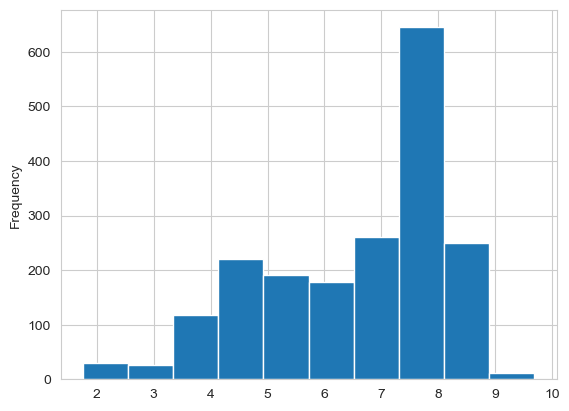

In [56]:
df_soc_score['score'].plot(kind='hist')

<Axes: xlabel='year', ylabel='score'>

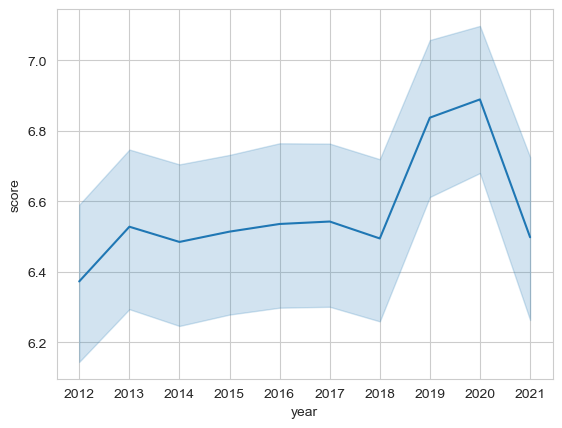

In [57]:
sns.lineplot(data=df_soc_score, x='year', y='score')

In [58]:
df_gov_score = score(df_gov_scaled, gov_ind)

In [59]:
df_gov_score

ind,iso3,year,CC.EST,IT.NET.USER.ZS,PV.EST,RL.EST,VA.EST,score
0,AFG,2012-01-01,0.431274,0.566943,1.033383,1.780543,2.470719,1.26
1,AGO,2012-01-01,0.811177,0.800334,5.775602,2.633179,2.951248,2.59
2,ALB,2012-01-01,2.172307,5.134612,6.349768,4.343016,5.711801,4.74
3,AND,2012-01-01,7.181259,8.595798,9.700906,8.743128,9.260228,8.70
4,ARE,2012-01-01,6.917973,8.834858,8.702798,6.761668,3.140833,6.87
...,...,...,...,...,...,...,...,...
1925,WSM,2021-01-01,6.225071,3.361094,8.775547,7.290091,7.649102,6.66
1926,YEM,2021-01-01,0.540298,2.671835,0.134859,1.287109,1.008158,1.13
1927,ZAF,2021-01-01,4.715957,7.000000,5.631658,5.041117,7.353394,5.95
1928,ZMB,2021-01-01,2.874583,1.980000,5.876987,3.895129,4.449278,3.82


In [60]:
df_gov_score.describe()

ind,CC.EST,IT.NET.USER.ZS,PV.EST,RL.EST,VA.EST,score
count,1910.000000,1920.000000,1930.000000,1930.000000,1930.000000,1930.000000
mean,4.179173,5.041539,6.280346,5.160405,5.533193,5.225171
std,2.464939,2.983459,2.236734,2.235525,2.561607,2.179457
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.060000
25%,2.383739,2.304482,4.948319,3.550315,3.405511,3.592500
50%,3.656924,5.231905,6.460029,4.813242,5.694486,5.070000
75%,5.850287,7.679389,8.135895,6.623211,7.802677,6.830000
max,10.000000,10.000000,10.000000,10.000000,10.000000,9.860000


<Axes: ylabel='Frequency'>

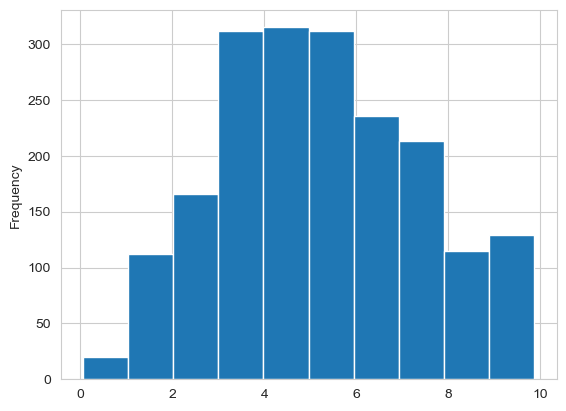

In [61]:
df_gov_score['score'].plot(kind='hist')

<Axes: xlabel='year', ylabel='score'>

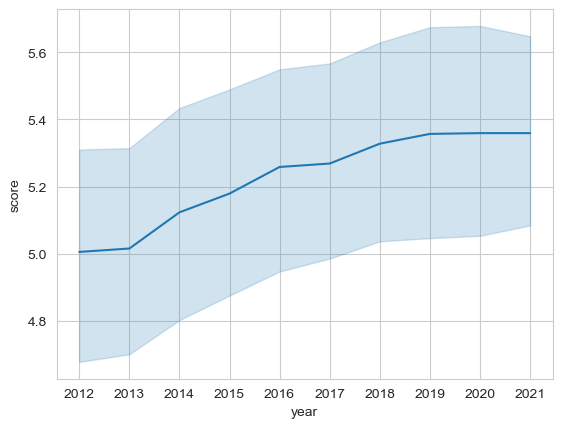

In [62]:
sns.lineplot(data=df_gov_score, x='year', y='score')

In [63]:
print(df_soc_score.shape)
print(df_gov_score.shape)
print(df_soc_score.columns)
print(df_gov_score.columns)

(1930, 8)
(1930, 8)
Index(['iso3', 'year', 'EG.ELC.ACCS.ZS', 'SE.XPD.TOTL.GB.ZS', 'SH.DYN.MORT',
       'SL.UEM.TOTL.ZS', 'SP.DYN.LE00.IN', 'score'],
      dtype='object', name='ind')
Index(['iso3', 'year', 'CC.EST', 'IT.NET.USER.ZS', 'PV.EST', 'RL.EST',
       'VA.EST', 'score'],
      dtype='object', name='ind')


### SCORE DATAFRAMES FOR UPLOAD

In [64]:
def drop_ind(df, lst_ind):
    df = df.drop(lst_ind, axis=1)
    return df

In [65]:
df_soc_scr = drop_ind(df_soc_score, soc_ind)
df_gov_scr = drop_ind(df_gov_score, gov_ind)

In [66]:
df_soc_scr = df_soc_scr.rename(columns={'score':'soc_score'})
df_gov_scr = df_gov_scr.rename(columns={'score':'gov_score'})

In [67]:
df_soc_scr = df_soc_scr.sort_values(by=['iso3', 'year'], ascending=[True, True]).reset_index(drop=True)
df_gov_scr = df_gov_scr.sort_values(by=['iso3', 'year'], ascending=[True, True]).reset_index(drop=True)

In [68]:
print(df_soc_scr.head())
print(df_gov_scr.head())

ind iso3       year  soc_score
0    AFG 2012-01-01       5.10
1    AFG 2013-01-01       5.25
2    AFG 2014-01-01       5.64
3    AFG 2015-01-01       5.17
4    AFG 2016-01-01       5.72
ind iso3       year  gov_score
0    AFG 2012-01-01       1.26
1    AFG 2013-01-01       1.19
2    AFG 2014-01-01       1.48
3    AFG 2015-01-01       1.49
4    AFG 2016-01-01       1.45


### Scaling the final Score

In [69]:
gov_score = ['gov_score']
soc_score = ['soc_score']


In [70]:
df_gov_scr = minmax_scale(df_gov_scr, gov_score)
df_soc_scr = minmax_scale(df_soc_scr, soc_score)

In [71]:
df_gov_scr = df_gov_scr.sort_values(by=['iso3', 'year'], ascending=[True, True]).reset_index(drop=True)
df_soc_scr = df_soc_scr.sort_values(by=['iso3', 'year'], ascending=[True, True]).reset_index(drop=True)

## Save DataFrame

In [72]:
df_gov_scr.to_csv('data/df_gov_scr.csv')
df_soc_scr.to_csv('data/df_soc_scr.csv')

## UPLOAD TO POSTGRES

In [85]:
import psycopg2

In [86]:
schema = 'capstone_travel_index'
engine = sf.get_engine()

In [87]:
# table_name = 'df_gov_scr'

# if engine!=None:
#     try:
#         df_gov_scr.to_sql(name=table_name, # Name of SQL table
#                         con=engine, # Engine or connection
#                         if_exists='replace', # Drop the table before inserting new values 
#                         schema=schema, # Use schmea that was defined earlier
#                         index=False, # Write DataFrame index as a column
#                         chunksize=5000, # Specify the number of rows in each batch to be written at a time
#                         method='multi') # Pass multiple values in a single INSERT clause
#         print(f"The {table_name} table was imported successfully.")
#     # Error handling
#     except (Exception, psycopg2.DatabaseError) as error:
#         print(error)
#         engine = None

___